Implementation of EAST and CRAFT using Python. This code is part of the paper "Text Detection in Natural Scene Images using CRAFT and EAST" by Henry Febrian for the module Computer Graphics and Image Processing by Prof. Erik Rodner. (Adapted from Adrian Rosebrock (2018) https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/, last updated July 2021)

1. Imports. The corresponding files are already available in the 'bvlecture' environment, excluding imutils. It can be installed using 'pip install imutils'.

In [74]:
import os, sys
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

2. Function for EAST detection

In [75]:
def east(img, width, height):
    # Load the pretrained network and store it in a variable
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    # Constructing a list of layer names
    # The first layer is our output sigmoid activation which gives us the probability of a region containing text or not.
    # The second layer is the output feature map that represents the “geometry” of the image.
    # We’ll be able to use this geometry to derive the bounding box coordinates of the text in the input image.
    # (Rosebrock, 2018)
    layerNames = [
            "feature_fusion/Conv_7/Sigmoid",
            "feature_fusion/concat_3"]
    
    image = img.copy() # Storing the original image to be used later
    
    if len(img.shape) == 2:
        img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    (H, W) = img.shape[:2]
    
    # The image will need to be 'prepped' before being passed into EAST
    # IMPORTANT: EAST requires the image dimensions to be a multiple of 32
    
    (newW, newH) = (width, height) # 640 seems optimal at the moment. At 320 the network misses a lot of text
    
    # Determining the ratio of the new dimensions with the original image
    rW = W / float(newW)
    rH = H / float(newH)
    
    # Resize the image
    img = cv2.resize(img, (newW, newH))
    
    (H, W) = img.shape[:2]
    
    
    # Constructing a binary large object from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    start = time.time()
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
                # compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
            # scale the bounding box coordinates based on the respective
            # ratios
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
            # draw the bounding box on the image
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    elapsed_time = (time.time() - start)
    return image, elapsed_time

3. Let us see how the algorithm performs on some sample images

In [76]:
def tryFunc(path, w, h):
    image = cv2.imread(path)

    out_image, time = east(image, w, h)

    cv2.imwrite("sample_output.jpeg", out_image)
    # Reading image
    image = cv2.imread("sample_output.jpeg")

    # Displaying image
    plt.imshow(image)
    plt.show()
    print("Elapsed time: ", time)

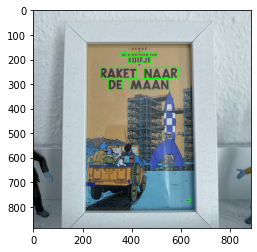

Elapsed time:  0.9059991836547852


In [77]:
tryFunc("img/easy/easy4.JPeG", 960, 960)

A small information on the image and stating my reasons for the parameters chosen: the original dimension is 886x886 pixels. This image is taken with the 'square' settings using an iPhone 11, inside my room with optimal lighting. Only hindrance is that the picture is a little bit dusty. Since EAST requires the image's dimension to be a multiply of 32, the nearest option is 960. (Image taken by myself)

It detects almost everything, except for the "HERGE" word at the top. We'll let that slide, after all it's too small and spaced apart. Let's try it on something harder:

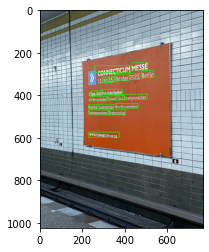

Elapsed time:  0.8670008182525635


In [78]:
tryFunc("img/inter/inter7.jpeg", 960, 960)

The original dimensions of this image is 768x1024 pixels. This is a billboard inside U-Tierpark - shielded from the cruel weather and supplied with optimal lighting. Although it is a bit skewed, - the image was a walk in the park for the algorithm. (Image taken by myself)

Harder, shall we?

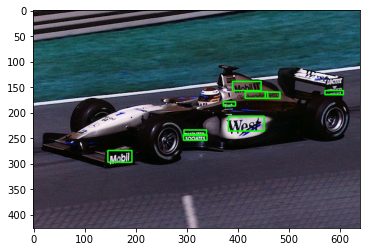

Elapsed time:  0.42799830436706543


In [79]:
tryFunc("img/hard/hard7.jpg", 640, 640)

The original dimensions of this image is 640x426 pixels, hence the 640 parameter. This is Mika Hakkinen driving the McLaren MP4/14 at the 1999 Canadian Grand Prix. This image is categorized as hard because there are movement, wrapped texts, and it's taken with an old camera.

By Paul Lannuier from Sussex, NJ, USA - Mika Hakkinen (McLaren Mercedes), CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=4296733

Well, this is a pleasant surprise. With an elapsed time of 0.412 seconds, this is the fastest image detected by far. The algorithm detects almost every sponsor on the side of Mika's car, including the distorted 'Mercedes-Benz' text on the left engine cover. It is an odd surprise that the algorithm missed the 'WEST' text on the rear wing, but managed to detect the small text above the rear tyre (rightmost green box).

The function below is used to evaluate the algorithm using my dataset:

In [80]:
def eval(path):
    for img in glob.glob(path):
        tryFunc(img, 640, 640)

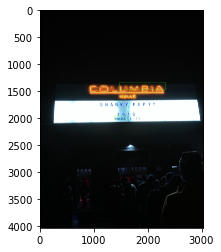

Elapsed time:  0.41886234283447266


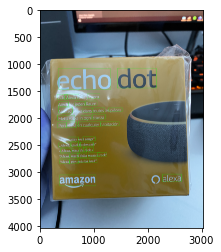

Elapsed time:  0.4249992370605469


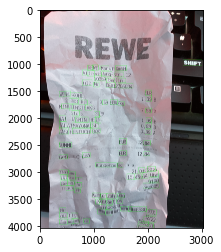

Elapsed time:  0.4270000457763672


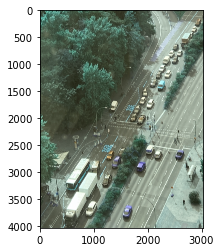

Elapsed time:  0.4069995880126953


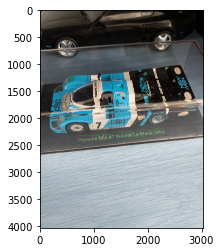

Elapsed time:  0.41522645950317383


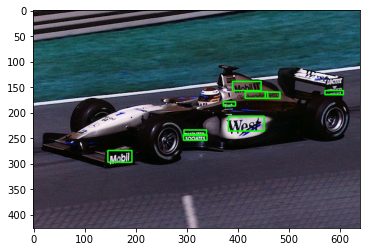

Elapsed time:  0.404998779296875


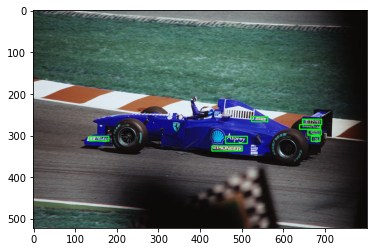

Elapsed time:  0.40799975395202637


In [81]:
eval("img/hard/*.jpg")

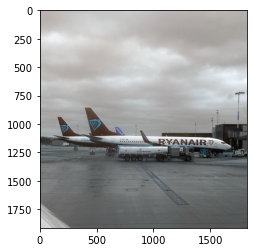

Elapsed time:  0.41199827194213867


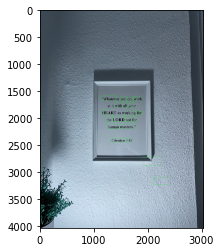

Elapsed time:  0.4220004081726074


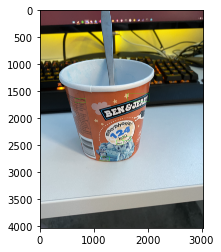

Elapsed time:  0.40799903869628906


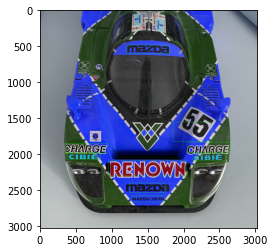

Elapsed time:  0.44299888610839844


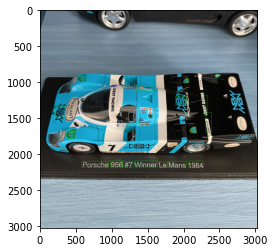

Elapsed time:  0.41399693489074707


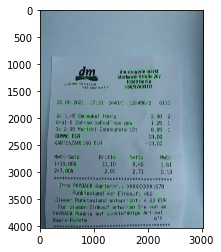

Elapsed time:  0.43565917015075684


In [82]:
eval("img/inter/*.jpg")

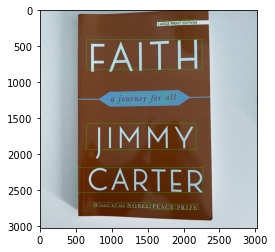

Elapsed time:  0.47806262969970703


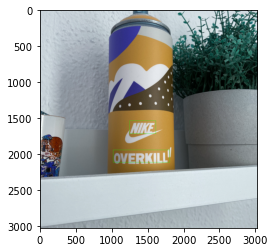

Elapsed time:  0.44499850273132324


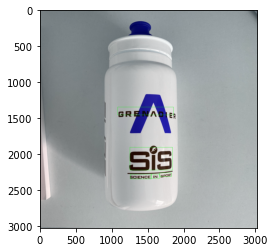

Elapsed time:  0.41300010681152344


In [83]:
eval("img/easy/*.jpg")